# Install Packages

In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install xgboost
!pip install scikit-learn

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

# Data Pre-processing

In [ ]:
# # Load the CSV file
# file_path = 'sensor_data_vendor_data.csv'
# df = pd.read_csv(file_path)

# # Create a new directory for the splitted data
# output_dir = 'splitted_data'
# os.makedirs(output_dir, exist_ok=True)

# # Split the dataframe by 'deviceName' and save each as a CSV
# for device_name, group in df.groupby('deviceName'):
#     # Drop the 'deviceName' column
#     group = group.drop(columns='deviceName')
#     # Generate the file name and path
#     file_name = f"{device_name.replace(' ', '_')}.csv"
#     file_path = os.path.join(output_dir, file_name)
#     group = group[['Time','_field','Temperature']]
#     # Save to CSV
#     group.to_csv(file_path, index=False)

# print(f"sensor_data.csv has been splitted in the '{output_dir}' folder into respective Device Name")

<h1 style="color:red";>Temperature</h1>

In [ ]:
file_path_temperature = 'sensor_data_vendor_data.csv'
df = pd.read_csv(file_path_temperature)

# Filter for temperature data
df_temperature = df[['Time','Temperature']].copy()

# Convert 'Time' column to datetime format
df_temperature['Time'] = pd.to_datetime(df_temperature['Time'])

# Convert datetime to the desired string format and rename the 'Time' column to 'dateTime'
df_temperature['Time'] = df_temperature['Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
df_temperature.rename(columns={'Time': 'dateTime'}, inplace=True)

# Set the 'dateTime' column as index and ensure it's in datetime format
df_temperature.set_index('dateTime', inplace=True)
df_temperature.index = pd.to_datetime(df_temperature.index)

df_temperature.dropna(inplace=True)

# Extract numeric value from the 'Temperature' column and convert to float
df_temperature['Temperature'] = df_temperature['Temperature'].str.extract('([0-9.]+)').astype(float)

print(df_temperature)

                     Temperature
dateTime                        
2023-12-31 20:00:00         24.0
2023-12-31 14:00:00         24.1
2023-12-31 08:00:00         23.9
2023-12-31 02:00:00         23.7
2023-12-30 20:00:00         23.5
...                          ...
2023-09-10 14:00:00         25.2
2023-09-10 08:00:00         24.8
2023-09-10 02:00:00         24.3
2023-09-09 20:00:00         23.9
2023-09-09 14:00:00         23.1

[454 rows x 1 columns]


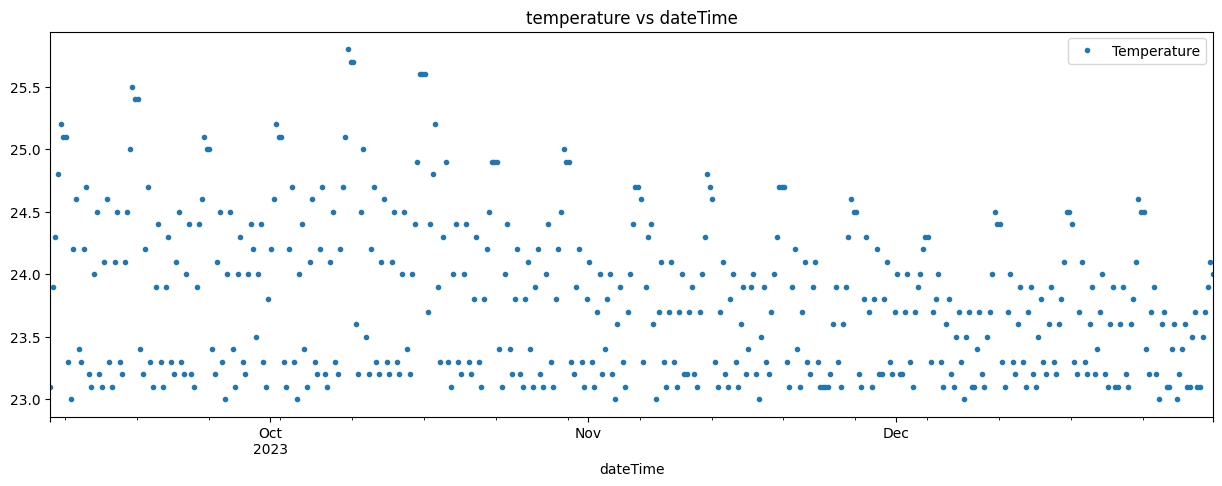

In [ ]:
df_temperature.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='temperature vs dateTime')
plt.show()

# Train / Test Split

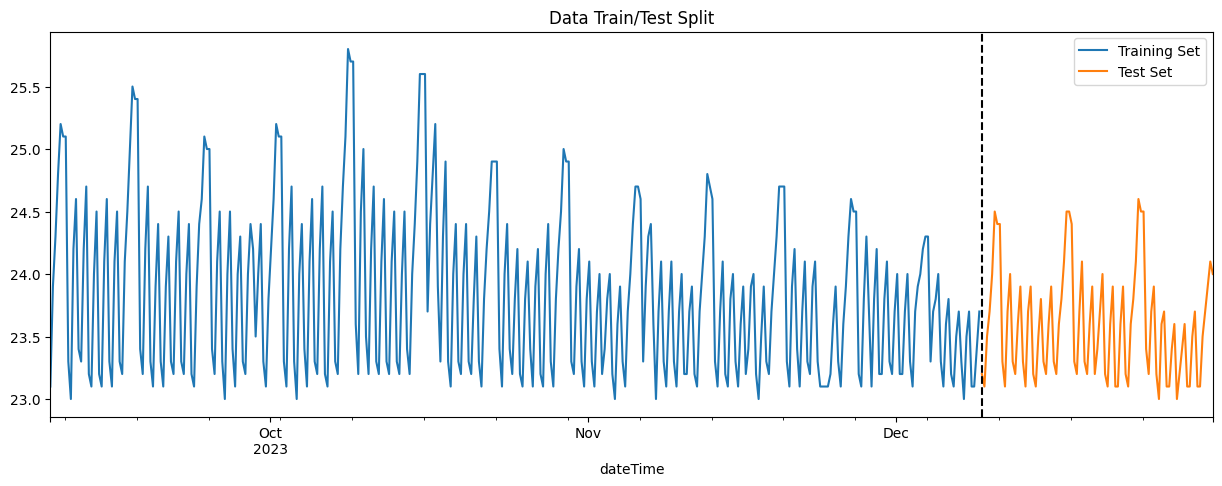

In [ ]:
# Assuming df is your DataFrame and it's already loaded and indexed by datetime
# Ensure your index is sorted
df_temperature = df_temperature.sort_index()

# Calculate the split point
split_point = int(len(df_temperature) * 0.8)

# Split the data
train = df_temperature.iloc[:split_point]
test = df_temperature.iloc[split_point:]

# Visualize the split
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')

# Using the date at the split point for the vertical line might not always be accurate
# if dates are not uniformly distributed, but it gives a visual approximation.
split_date = df_temperature.index[split_point]
ax.axvline(split_date, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()


# Feature Creation

In [ ]:
def create_features(df_temperature):
    """
    Create time series features based on time series index.
    """
    df_temperature = df_temperature.copy()
    df_temperature['hour'] = df_temperature.index.hour
    df_temperature['dayofweek'] = df_temperature.index.dayofweek
    df_temperature['quarter'] = df_temperature.index.quarter
    df_temperature['month'] = df_temperature.index.month
    df_temperature['year'] = df_temperature.index.year
    df_temperature['dayofyear'] = df_temperature.index.dayofyear
    df_temperature['dayofmonth'] = df_temperature.index.day
    df_temperature['weekofyear'] = df_temperature.index.isocalendar().week
    return df_temperature

df_temperature = create_features(df_temperature)
df_temperature

,Temperature,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
dateTime,,,,,,,,,
2023-09-09 14:00:00,23.1,14,5,3,9,2023,252,9,36
2023-09-09 20:00:00,23.9,20,5,3,9,2023,252,9,36
2023-09-10 02:00:00,24.3,2,6,3,9,2023,253,10,36
2023-09-10 08:00:00,24.8,8,6,3,9,2023,253,10,36
2023-09-10 14:00:00,25.2,14,6,3,9,2023,253,10,36
...,...,...,...,...,...,...,...,...,...
2023-12-30 20:00:00,23.5,20,5,4,12,2023,364,30,52
2023-12-31 02:00:00,23.7,2,6,4,12,2023,365,31,52
2023-12-31 08:00:00,23.9,8,6,4,12,2023,365,31,52


# Visualize our Feature / Target Relationship

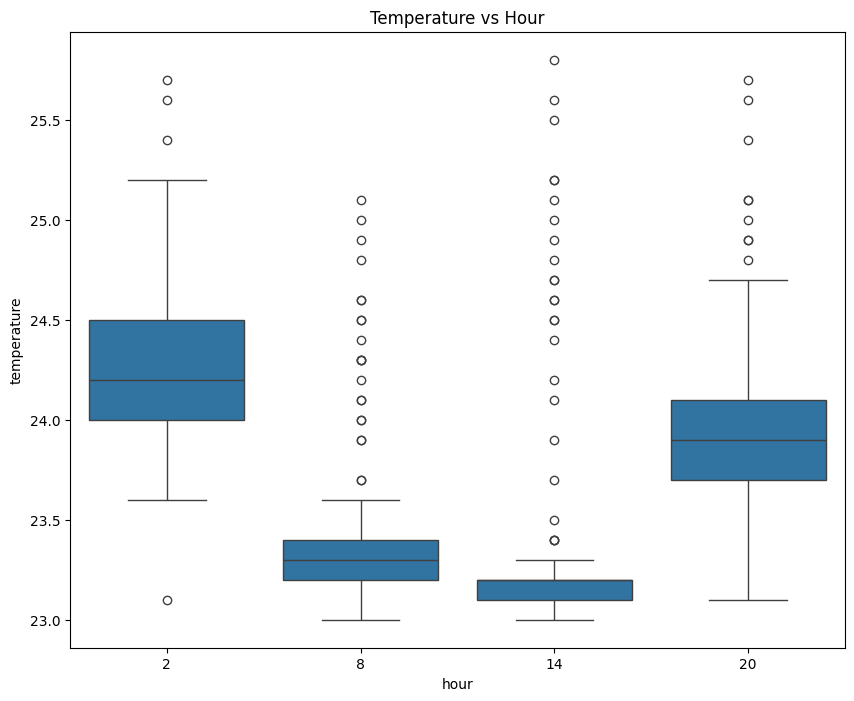

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_temperature, x='hour', y='Temperature')
ax.set_title('Temperature vs Hour')
ax.set_ylabel('temperature')
plt.show()

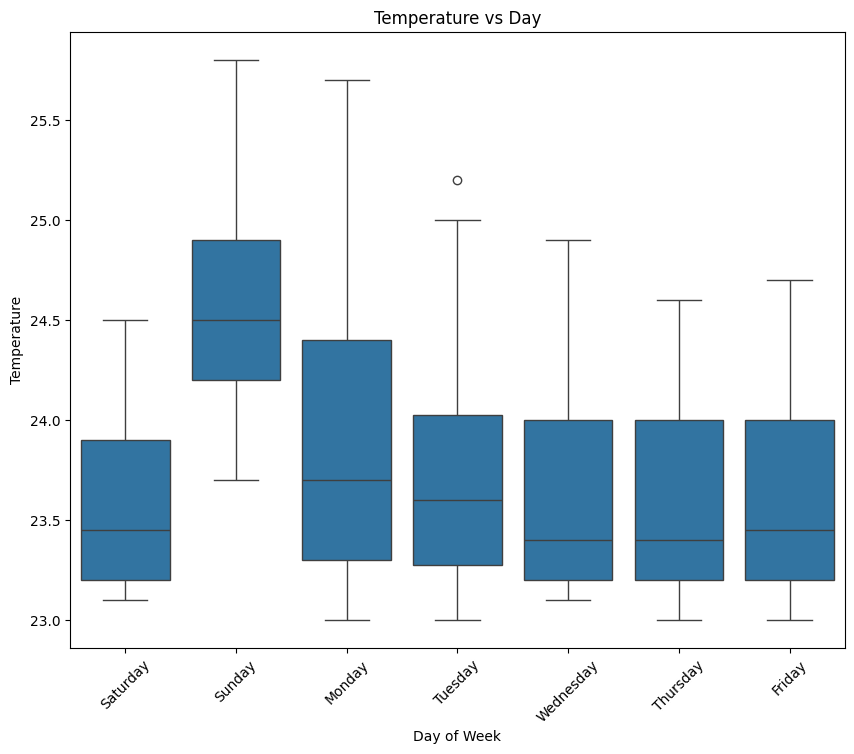

In [ ]:
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

# Map the 'dayofweek' integers to day names
df_temperature['dayofweek_name'] = df_temperature['dayofweek'].map(day_names)

# Plot using the new 'dayofweek_name' column
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_temperature, x='dayofweek_name', y='Temperature')
ax.set_title('Temperature vs Day')
ax.set_xlabel('Day of Week') # Update label to reflect change
ax.set_ylabel('Temperature')
plt.xticks(rotation=45) # Optional: rotate the day names for better readability
plt.show()


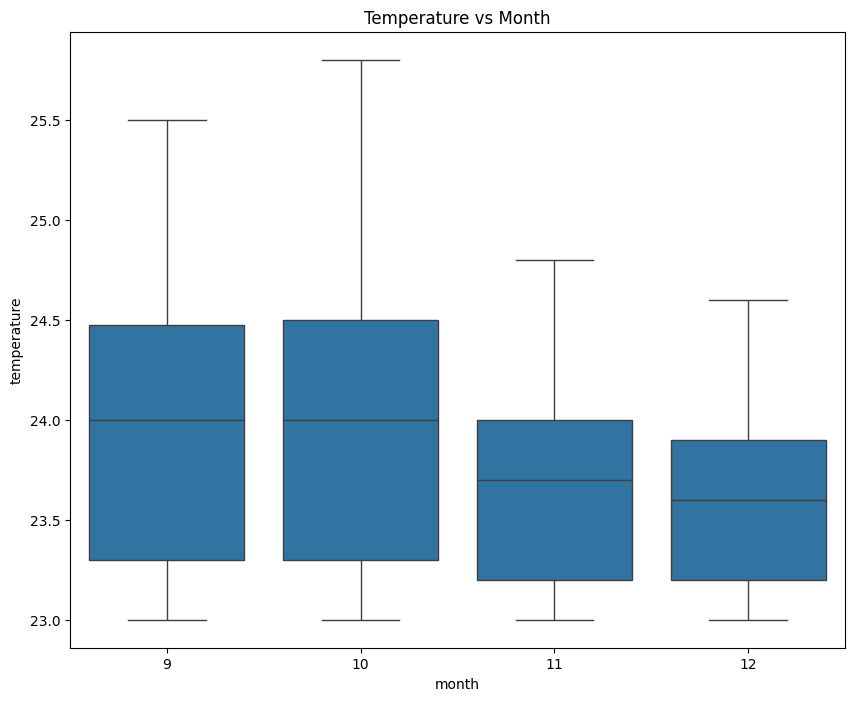

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_temperature, x='month', y='Temperature')
ax.set_title('Temperature vs Month')
ax.set_ylabel('temperature')
plt.show()

# Create our Model

In [ ]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
# FEATURES = ['dayofyear', 'hour', 'dayofweek']
# FEATURES = ['dayofyear', 'hour']
TARGET = 'Temperature'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:23.11493	validation_1-rmse:22.85697
[100]	validation_0-rmse:8.50577	validation_1-rmse:8.23924
[200]	validation_0-rmse:3.16143	validation_1-rmse:2.87424
[300]	validation_0-rmse:1.20385	validation_1-rmse:0.98251
[400]	validation_0-rmse:0.49628	validation_1-rmse:0.40868
[500]	validation_0-rmse:0.25543	validation_1-rmse:0.21900
[600]	validation_0-rmse:0.17869	validation_1-rmse:0.15678
[700]	validation_0-rmse:0.15478	validation_1-rmse:0.14210
[800]	validation_0-rmse:0.14516	validation_1-rmse:0.13957


/common/home/projectgrps/IS460/IS460G6/jupyterlab-venv-py311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [11:50:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[870]	validation_0-rmse:0.14071	validation_1-rmse:0.13958


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

# Feature Importance

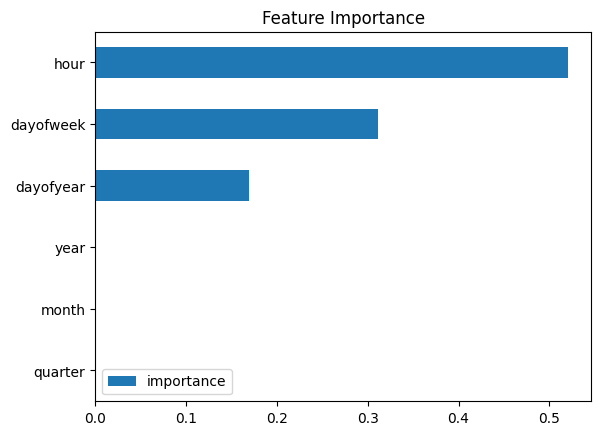

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

In [ ]:
test['prediction'] = reg.predict(X_test)
df_temperature = df_temperature.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df_temperature[['Temperature']].plot(figsize=(15, 5))
df_temperature['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

ValueError: feature_names mismatch: ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2', 'lag3'] ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
expected lag1, lag3, lag2 in input data

# Score (RMSE)

In [ ]:
score = np.sqrt(mean_squared_error(test['Temperature'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 0.14


# Calculate Error
- Look at the worst and best predicted days

In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2023-12-24    0.180811
2023-12-10    0.175428
2023-12-20    0.169881
2023-12-28    0.157075
2023-12-17    0.155811
2023-12-16    0.155298
2023-12-31    0.144189
2023-12-15    0.132407
2023-12-25    0.125589
2023-12-13    0.119881
Name: error, dtype: float64

# 3. Lag Features
- What was the target (x) days in the past.

In [ ]:
def add_hourly_lags(df_temperature):
    target_map = df_temperature['Temperature'].to_dict()
    # df_temperature['lag1'] = (df_temperature.index - pd.Timedelta('1 hours')).map(target_map)
    # df_temperature['lag2'] = (df_temperature.index - pd.Timedelta('2 hours')).map(target_map)
    # df_temperature['lag3'] = (df_temperature.index - pd.Timedelta('3 hours')).map(target_map)
    df_temperature['lag1'] = (df_temperature.index - pd.Timedelta('364 days')).map(target_map)
    df_temperature['lag2'] = (df_temperature.index - pd.Timedelta('728 days')).map(target_map)
    df_temperature['lag3'] = (df_temperature.index - pd.Timedelta('1092 days')).map(target_map)
    return df_temperature


In [ ]:
df_temperature = add_hourly_lags(df_temperature)

# Predicting the Future
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [ ]:
# Retrain on all data
df_temperature = create_features(df_temperature)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
# TARGET = 'PJME_MW'
# FEATURES = ['dayofyear', 'hour']
TARGET = 'Temperature'

X_all = df_temperature[FEATURES]
y_all = df_temperature[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:23.06384
[100]	validation_0-rmse:8.48046
[200]	validation_0-rmse:3.14637
[300]	validation_0-rmse:1.19435
[400]	validation_0-rmse:0.48823
[499]	validation_0-rmse:0.24782


/common/home/projectgrps/IS460/IS460G6/jupyterlab-venv-py311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [11:50:37] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [ ]:
df_temperature.index.max()

Timestamp('2023-12-31 20:00:00')

In [ ]:
# Create future dataframe
future = pd.date_range('2024-03-12','2024-03-31', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df_temperature['isFuture'] = False
df_and_future = pd.concat([df_temperature, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_hourly_lags(df_and_future)

In [ ]:
future_w_features = df_and_future.query('isFuture').copy()

# Predict the future

In [ ]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

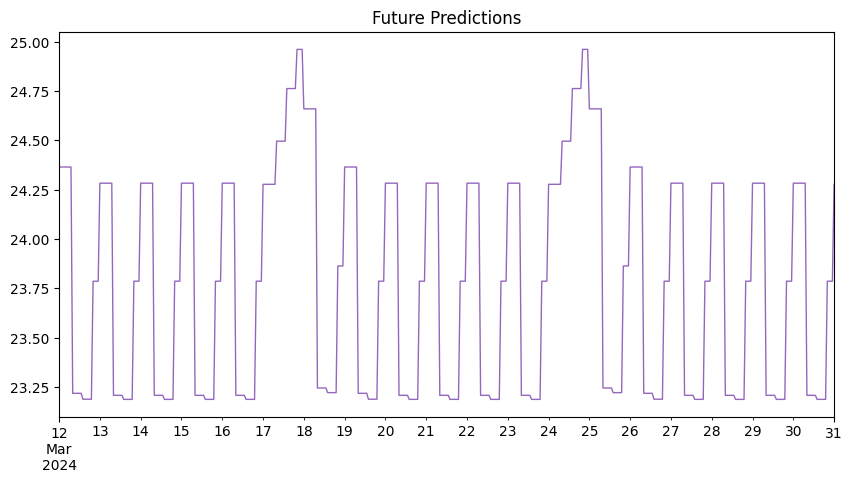

In [ ]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

# Saving Model

In [ ]:
# Save model
reg.save_model('model_temperature_vendor.json')

In [ ]:
!ls -lh

total 12M
-rw-rw-r--. 1 IS460G6 IS460G6  15K Mar 10 17:34 archieve.ipynb
-rw-rw-r--. 1 IS460G6 IS460G6  18K Mar  4 17:43 Draft1.ipynb
-rw-rw-r--. 1 IS460G6 IS460G6 424K Mar  4 17:41 lstm_model.h5
-rw-rw-r--. 1 IS460G6 IS460G6 2.3K Mar  4 17:18 lstm_model.py
-rw-rw-r--. 1 IS460G6 IS460G6  740 Mar  4 17:18 lstm_predict.py
-rw-rw-r--. 1 IS460G6 IS460G6 428K Mar 11 10:47 model_co2.json
-rw-rw-r--. 1 IS460G6 IS460G6 489K Mar 11 11:45 model_co2_vendor.json
-rw-rw-r--. 1 IS460G6 IS460G6 246K Mar 11 10:47 model_humidity.json
-rw-rw-r--. 1 IS460G6 IS460G6 334K Mar 11 11:45 model_humidity_vendor.json
-rw-rw-r--. 1 IS460G6 IS460G6 246K Mar 10 17:41 model.json
-rw-rw-r--. 1 IS460G6 IS460G6 346K Mar 11 10:47 model_temperature.json
-rw-rw-r--. 1 IS460G6 IS460G6 375K Mar 11 11:50 model_temperature_vendor.json
-rw-rw-r--. 1 IS460G6 IS460G6 3.9M Mar 10 00:41 PJME_hourly.csv
-rw-rw-r--. 1 IS460G6 IS460G6  83K Mar 11 10:46 sensor_data.csv
-rw-rw-r--. 1 IS460G6 IS460G6  63K Mar 11 10:39 sensor_data_vendor

# Using Model from Saved Model

<Axes: title={'center': 'Future Predictions'}>

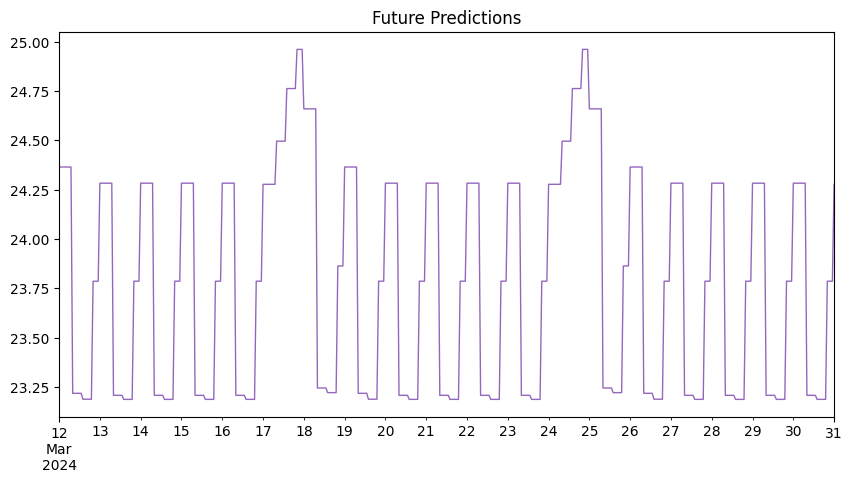

In [ ]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model_temperature_vendor.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')